## Colab Master Pipeline — T5-Nano (Python → C++)

End-to-end pipeline:
- Clone repo
- Install deps
- XLCoST data prep → `data/processed/`
- Train tokenizer → `custom_tokenizer/`
- Build T5-Nano (random init)
- Train → `t5_nano_checkpoints/` + `final_model/`
- Inference demo

**Colab GPU**: Runtime → Change runtime type → GPU


In [1]:
# --- 0) Clone repo (idempotent) ---
%cd /content

REPO_URL = "https://github.com/ns-1456/NMT.git"
REPO_DIR = "NMT"
BRANCH = "python-to-cpp-transpiler"  # change if needed

import os

if not os.path.isdir(REPO_DIR):
    !git clone --depth 1 -b {BRANCH} {REPO_URL} {REPO_DIR}

%cd /content/{REPO_DIR} 
!git status -sb || true


/content
Cloning into 'NMT'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 37 (delta 5), reused 30 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (37/37), 3.48 MiB | 19.70 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Filtering content: 100% (7/7), 318.72 MiB | 47.22 MiB/s, done.
/content/NMT
## python-to-cpp-transpiler...origin/python-to-cpp-transpiler


In [2]:
# --- 1) Install deps (avoid reinstalling torch in Colab) ---
!pip -q install -U pip
!pip -q install transformers datasets tokenizers pandas scikit-learn accelerate gdown tqdm matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 30.3 MB/s eta 0:00:00a 0:00:01


In [3]:
from __future__ import annotations

import json
import os
import subprocess
from pathlib import Path

os.environ["TOKENIZERS_PARALLELISM"] = "false"

REPO_ROOT = Path.cwd()
RAW_DIR = REPO_ROOT / "data" / "raw"
PROCESSED_DIR = REPO_ROOT / "data" / "processed"
TOKENIZER_DIR = REPO_ROOT / "custom_tokenizer"
CHECKPOINT_DIR = REPO_ROOT / "t5_nano_checkpoints"
FINAL_MODEL_DIR = REPO_ROOT / "final_model"

QUICK_RUN = True
MAX_SAMPLES = 2000 if QUICK_RUN else None
EPOCHS = 1 if QUICK_RUN else 30
BATCH_SIZE = 8 if QUICK_RUN else 32

print("repo:", REPO_ROOT)
print("quick_run:", QUICK_RUN)


repo: /content/NMT
quick_run: True


## 2) Data prep (XLCoST)

This downloads + extracts XLCoST and writes:
- `data/processed/corpus.txt`
- `data/processed/train.jsonl`, `validation.jsonl`, `test.jsonl`
- `data/processed/xlcost_py_cpp_snippet/` (Arrow dataset, if `datasets` is installed)


In [4]:
# Clean stale artifacts that commonly cause confusion
subprocess.run(["rm", "-rf", str(RAW_DIR / "XLCoST_data")], check=False)
subprocess.run(["rm", "-rf", str(RAW_DIR / "__MACOSX")], check=False)
subprocess.run(["rm", "-f", str(RAW_DIR / "XLCoST_data.zip")], check=False)

cmd = ["python", "-u", "data_prep.py"]
if MAX_SAMPLES is not None:
    cmd += ["--max_samples", str(MAX_SAMPLES)]

print("Running:", " ".join(cmd))
proc = subprocess.run(cmd, text=True, capture_output=True)

print("\n--- data_prep.py stdout ---\n")
print(proc.stdout)

if proc.returncode != 0:
    print("\n--- data_prep.py stderr ---\n")
    print(proc.stderr)
    raise RuntimeError(f"data_prep.py failed with exit code {proc.returncode}")

print("\nProduced:")
for p in sorted(PROCESSED_DIR.glob("*")):
    print("-", p)


Running: python -u data_prep.py --max_samples 2000

--- data_prep.py stdout ---

[data_prep] Downloading XLCoST zip to data/raw/XLCoST_data.zip
[data_prep] Extracting data/raw/XLCoST_data.zip into data/raw
[data_prep] Using pair directory: data/raw/XLCoST_data/generation/pair_data_tok_1/C++-Python
[data_prep] train: 2000 examples (from 80100 total)
[data_prep] validation: 2000 examples (from 3913 total)
[data_prep] test: 2000 examples (from 7228 total)
[data_prep] Writing tokenizer corpus to data/processed/corpus.txt
[data_prep] Saving Arrow dataset to data/processed/xlcost_py_cpp_snippet
[data_prep] Writing JSONL exports
[data_prep] Sample (train[0]):
  source_prefix_ok: True
  source_len: 60  target_len: 34
[data_prep] Done.


Produced:
- /content/NMT/data/processed/corpus.txt
- /content/NMT/data/processed/test.jsonl
- /content/NMT/data/processed/train.jsonl
- /content/NMT/data/processed/validation.jsonl
- /content/NMT/data/processed/xlcost_py_cpp_snippet


In [5]:
# Quick sanity: locate where pair_data_tok_1 ended up (debug helper)
import os

hits = []
for root, dirs, _files in os.walk(RAW_DIR):
    if "pair_data_tok_1" in dirs:
        hits.append(Path(root))

print("Found roots containing pair_data_tok_1:")
for h in hits[:10]:
    print("-", h)


Found roots containing pair_data_tok_1:
- /content/NMT/data/raw/XLCoST_data/generation
- /content/NMT/data/raw/__MACOSX/XLCoST_data/generation


train rows: 2000


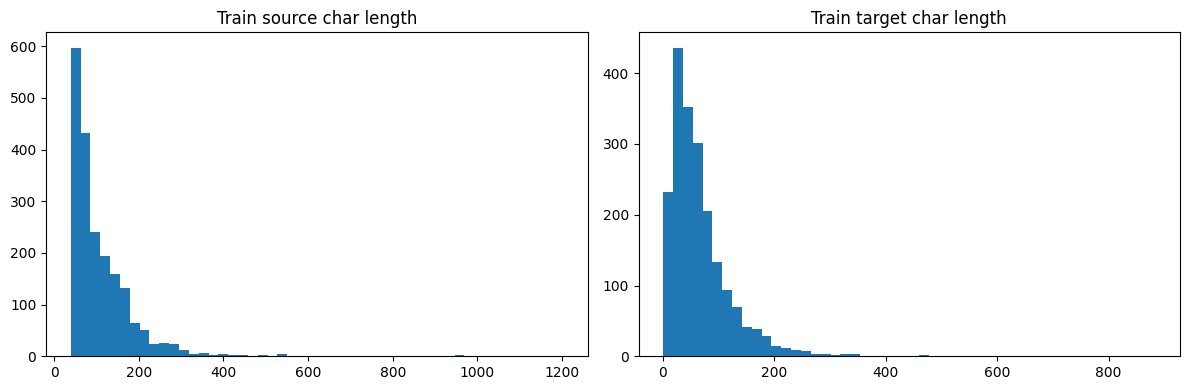

,source,target,source_len,target_len
0,"translate Python to C++: for i in range ( 1 , ...",for ( int i = 0 ; i < N ; ++ i ) {,60,34
1,translate Python to C++: from math import sqrt...,#include <bits/stdc++.h> NEW_LINE using namesp...,70,55
2,translate Python to C++: print ( result ) NEW_...,cout << result ; },50,18


In [6]:
# Inspect dataset + basic visualization
import pandas as pd
import matplotlib.pyplot as plt

arrow_dir = PROCESSED_DIR / "xlcost_py_cpp_snippet"
if arrow_dir.exists():
    from datasets import load_from_disk
    ds = load_from_disk(str(arrow_dir))
    train_df = pd.DataFrame(ds["train"])
else:
    train_df = pd.read_json(PROCESSED_DIR / "train.jsonl", lines=True)

print("train rows:", len(train_df))
train_df["source_len"] = train_df["source"].astype(str).map(len)
train_df["target_len"] = train_df["target"].astype(str).map(len)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].hist(train_df["source_len"], bins=50)
ax[0].set_title("Train source char length")
ax[1].hist(train_df["target_len"], bins=50)
ax[1].set_title("Train target char length")
plt.tight_layout()
plt.show()

train_df.head(3)


## 3) Train tokenizer (Byte-Level BPE)


In [7]:
subprocess.run(["python", "-u", "train_tokenizer.py"], check=True)
print("Tokenizer dir:", TOKENIZER_DIR)
!ls -la custom_tokenizer | head


Tokenizer dir: /content/NMT/custom_tokenizer
total 176
drwxr-xr-x 2 root root   4096 Jan 25 01:47 .
drwxr-xr-x 6 root root   4096 Jan 25 01:47 ..
-rw-r--r-- 1 root root  62751 Jan 25 01:49 merges.txt
-rw-r--r-- 1 root root 102537 Jan 25 01:49 vocab.json


## 4) Build T5-Nano + verify parameter count


In [8]:
import model_config

tok = model_config.load_tokenizer()
model = model_config.build_t5_nano(tok)
params = model_config.count_parameters(model)
print(f"T5-Nano parameter count: {params:,}")


T5-Nano parameter count: 20,727,040


## 5) Train

`train.py` uses `fp16=True`, so this requires a GPU.


In [10]:
!git pull

Already up to date.


In [ ]:
import torch

if not torch.cuda.is_available():
    raise RuntimeError("No CUDA GPU. In Colab: Runtime → Change runtime type → GPU")

# If you hit CUDA OOM, lower per_device_batch_size and increase gradient accumulation.
# Effective batch size ≈ per_device_batch_size * gradient_accumulation_steps
GRAD_ACCUM = 4 if QUICK_RUN else 1

cmd = [
    "python",
    "-u",
    "train.py",
    "--per_device_batch_size",
    str(BATCH_SIZE),
    "--gradient_accumulation_steps",
    str(GRAD_ACCUM),
    "--num_train_epochs",
    str(EPOCHS),
]
print("Running:", " ".join(cmd))

proc = subprocess.run(cmd, text=True, capture_output=True)
print("\n--- train.py stdout ---\n")
print(proc.stdout)
if proc.returncode != 0:
    print("\n--- train.py stderr ---\n")
    print(proc.stderr)
    raise RuntimeError(f"train.py failed with exit code {proc.returncode}")

print("Final model dir exists:", FINAL_MODEL_DIR.exists())


Running: python -u train.py --per_device_batch_size 8 --gradient_accumulation_steps 4 --num_train_epochs 1


In [ ]:
# Plot training curves (if trainer_state.json exists)
import matplotlib.pyplot as plt

trainer_states = list(CHECKPOINT_DIR.glob("checkpoint-*/trainer_state.json"))
if not trainer_states:
    root_state = CHECKPOINT_DIR / "trainer_state.json"
    trainer_states = [root_state] if root_state.exists() else []

if not trainer_states:
    print("No trainer_state.json found")
else:
    state_path = max(trainer_states, key=lambda p: p.stat().st_mtime)
    state = json.loads(state_path.read_text())
    logs = state.get("log_history", [])

    steps, train_losses = [], []
    eval_steps, eval_losses = [], []
    for item in logs:
        if "loss" in item and "eval_loss" not in item:
            steps.append(item.get("step"))
            train_losses.append(item["loss"])
        if "eval_loss" in item:
            eval_steps.append(item.get("step"))
            eval_losses.append(item["eval_loss"])

    plt.figure(figsize=(10, 4))
    if train_losses:
        plt.plot(steps, train_losses, label="train_loss")
    if eval_losses:
        plt.plot(eval_steps, eval_losses, label="eval_loss")
    plt.title("Training curves")
    plt.xlabel("step")
    plt.ylabel("loss")
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.show()


## 6) Inference demo


In [ ]:
import inference

sample_python = """\
def sum_upto(n):
    s = 0
    for i in range(n + 1):
        s += i
    return s
"""

print("=== Python ===")
print(sample_python)
print("=== C++ (generated) ===")
inference.translate(sample_python)
